In [1]:
import numpy as np, h5py
from scipy.misc import imresize

from theano.tensor.nnet import relu

from deepgraph.utils import common
from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *
from deepgraph.utils.logging import *

Couldn't import dot_parser, loading of dot files will not be possible.


  _____                _____                 _
 |  _  \              |  __ \               | |
 | | | |___  ___ _ __ | |  \/_ __ __ _ _ __ | |__
 | | | / _ \/ _ \ '_ \| | __| '__/ _` | '_ \| '_ \
 | |/ /  __/  __/ |_) | |_\ \ | | (_| | |_) | | | |
 |___/ \___|\___| .__/ \____/_|  \__,_| .__/|_| |_|
                | |                   | |
                |_|                   |_|


Available on GitHub: https://github.com/sebastian-schlecht/deepgraph



In [2]:
def load_data(db_file):
    # Read the MAT-File into memory
    log("Loading data from database", LOG_LEVEL_INFO)
    dataset = h5py.File(db_file)

    depth_field = dataset['depths']
    depths = np.array(depth_field[0:20])

    images_field = dataset['images']
    images = np.array(images_field[0:20]).astype(np.uint8)

    # Swap axes
    images = np.swapaxes(images, 2, 3)
    depths = np.swapaxes(depths, 1, 2)

    # Resizing
    log("Resizing input", LOG_LEVEL_INFO)
    img_scale = 0.5
    depth_scale = 0.125

    images_sized = np.zeros((images.shape[0],images.shape[1], int(images.shape[2]*img_scale), int(images.shape[3]*img_scale)), dtype=np.uint8)
    depths_sized = np.zeros((depths.shape[0],int(depths.shape[1]*depth_scale), int(depths.shape[2]*depth_scale)), dtype=np.float32)

    for i in range(len(images)):
        ii = imresize(images[i], img_scale)
        images_sized[i] = np.swapaxes(np.swapaxes(ii,1,2),0,1)

    # For this test, we down-sample the depth images to 64x48

    for d in range(len(depths)):
        dd = imresize(depths[d], depth_scale)
        depths_sized[d] = dd

    images = images_sized
    depths = depths_sized

    images_train, images_val = common.split_array(images, 0.9)
    depths_train, depths_val = common.split_array(depths, 0.9)
    return [(images_train, images_val),(depths_train, depths_val)]

In [9]:
# data = load_data('/home/ga29mix/nashome/data/nyu_depth_v2/nyu_depth_v2_labeled.mat')
data = load_data('./data/nyu_depth_v2_labeled.mat')
train_x, val_x = data[0]
train_y, val_y = data[1]

[2016-03-21 16:09:52] INFO: Loading data from database
[2016-03-21 16:09:52] INFO: Resizing input


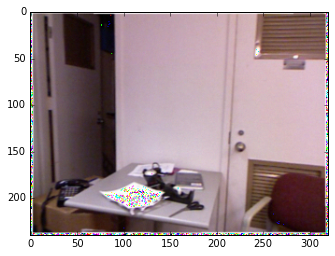

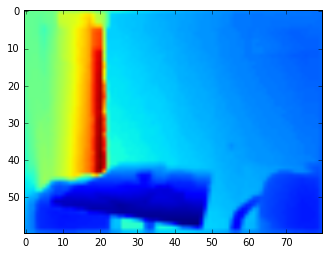

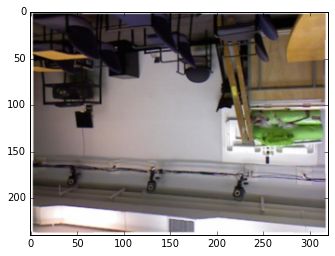

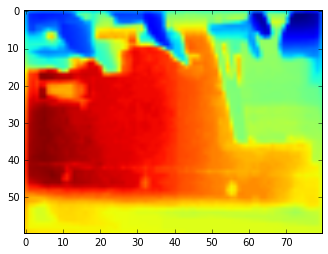

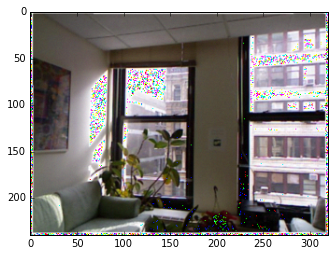

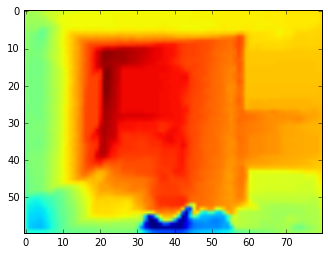

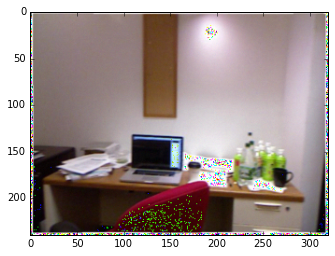

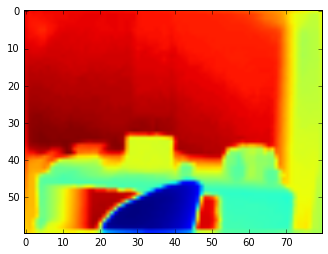

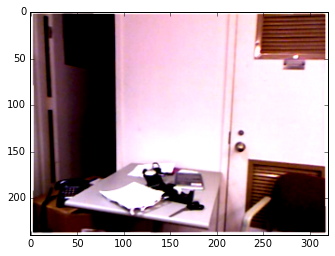

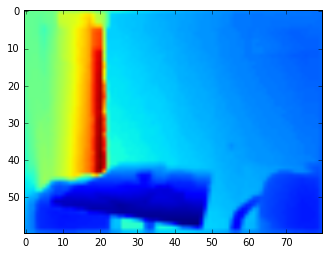

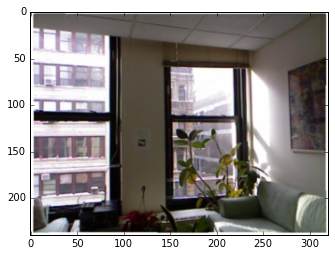

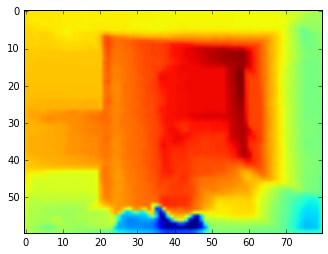

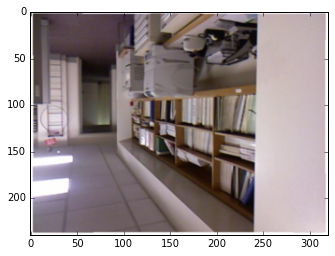

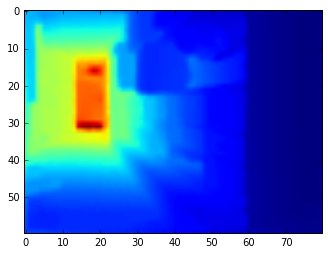

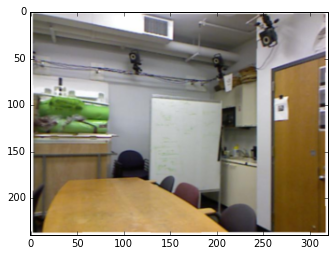

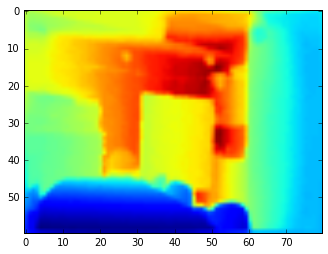

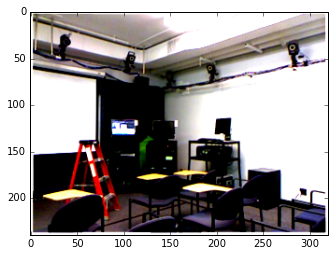

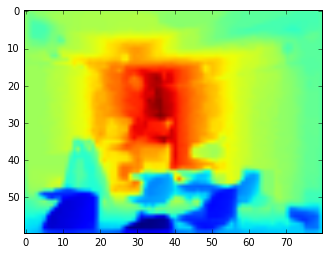

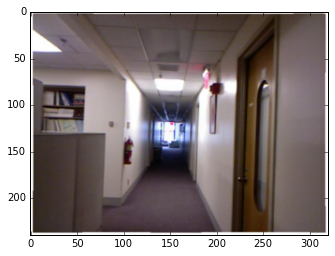

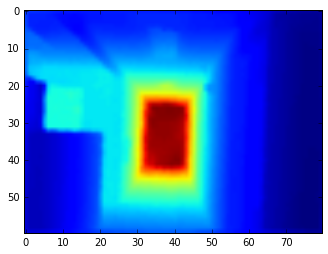

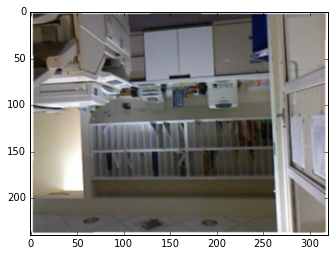

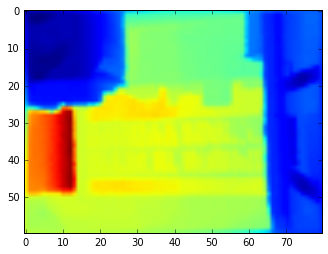

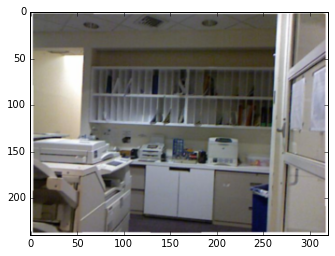

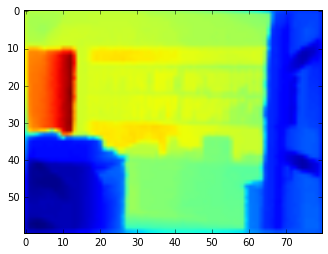

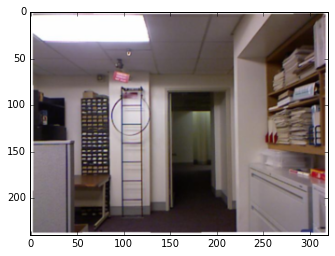

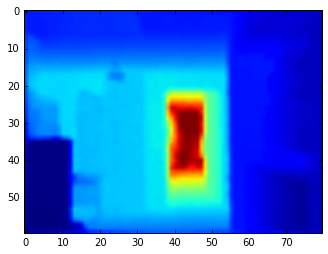

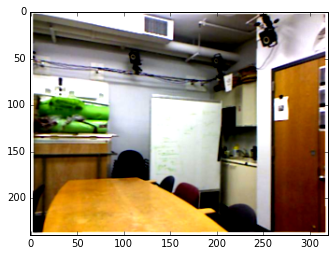

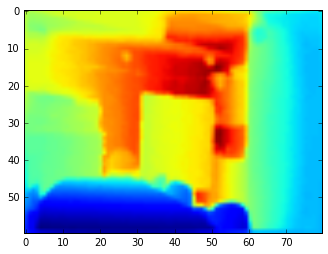

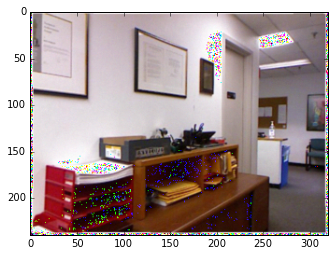

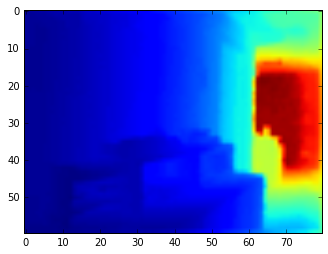

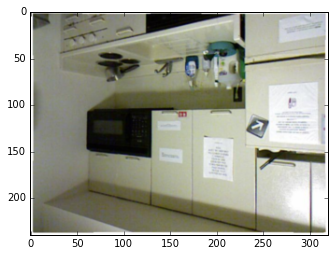

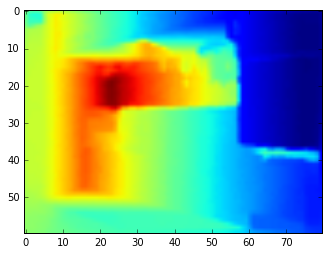

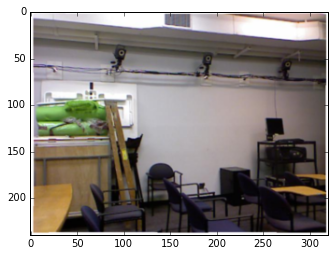

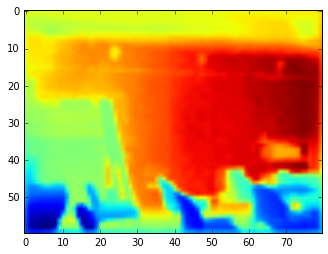

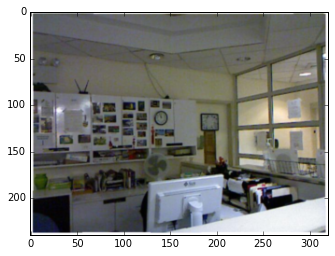

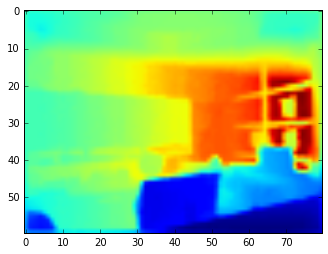

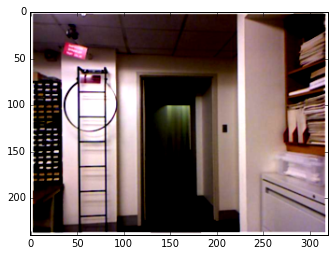

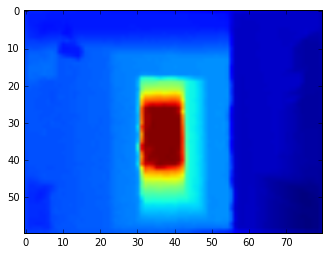

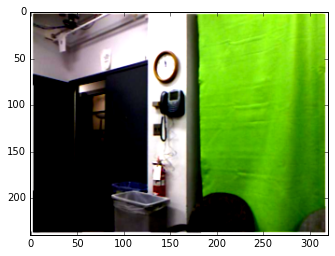

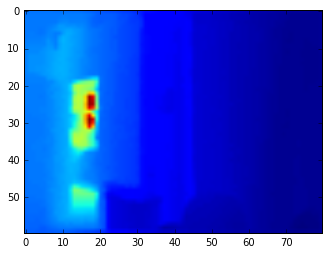

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

from deepgraph.utils.image import *

train_x_flip_h = np.zeros(train_x.shape, dtype=np.uint8)
train_x_flip_v = np.zeros(train_x.shape, dtype=np.uint8)
train_x_overexposed = np.zeros(train_x.shape, dtype=np.uint8)
train_x_noise = np.zeros(train_x.shape, dtype=np.uint8)

train_y_flip_h = np.zeros(train_y.shape, dtype=np.float32)
train_y_flip_v = np.zeros(train_y.shape, dtype=np.float32)
train_y_overexposed = np.zeros(train_y.shape, dtype=np.float32)
train_y_noise = np.zeros(train_y.shape, dtype=np.float32)

for i in range(train_x.shape[0]):
    train_x_flip_h[i] = flip_transformer_rgb(train_x[i], "horizontal")
    train_x_flip_v[i] = flip_transformer_rgb(train_x[i], "vertical")
    train_x_overexposed[i] = exposure_transformer_rgb(train_x[i])
    train_x_noise[i] = noise_transformer_rgb(train_x[i])

    train_y_flip_h[i] = flip_transformer_grey(train_y[i], "horizontal")
    train_y_flip_v[i] = flip_transformer_grey(train_y[i], "vertical")
    train_y_overexposed[i] = train_y[i].copy()
    train_y_noise[i] = train_y[i].copy()

##########
# Concat & shuffle
##########
train_x = np.concatenate([train_x, train_x_flip_h, train_x_flip_v, train_x_overexposed, train_x_noise], axis=0)
train_y = np.concatenate([train_y, train_y_flip_h, train_y_flip_v, train_y_overexposed, train_y_noise], axis=0)



train_x, train_y = shuffle_in_unison_inplace(train_x, train_y)


for i in range(20):
    plt.imshow(train_x[i].transpose((1,2,0)))
    plt.show()
    plt.imshow(train_y[i])
    plt.show()

In [5]:
#######################
# Data preprocessing
#######################
log("Preprocessing data", LOG_LEVEL_INFO)

# X
# Scale into 0-1 range
train_x = train_x.astype(np.float)
train_x *= 0.003921
# Subtract mean
train_mean = np.mean(train_x, axis=0)
idx = 0
for element in train_x:
    train_x[idx] = train_x[idx] - train_mean
    idx += 1
# Y
# Scale down by 100
train_y *= 0.01

[2016-03-19 18:41:20] INFO: Preprocessing data
